In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import random

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = '/content/drive/MyDrive/datasets/Innopolis_datasets/dinos.txt'


with open(path, 'r') as f:
    data = f.read().lower()
    data = data.replace('\n', '@')  # special symbol to complete a name

In [5]:
data

'aachenosaurus@aardonyx@abdallahsaurus@abelisaurus@abrictosaurus@abrosaurus@abydosaurus@acanthopholis@achelousaurus@acheroraptor@achillesaurus@achillobator@acristavus@acrocanthosaurus@acrotholus@actiosaurus@adamantisaurus@adasaurus@adelolophus@adeopapposaurus@aegyptosaurus@aeolosaurus@aepisaurus@aepyornithomimus@aerosteon@aetonyxafromimus@afrovenator@agathaumas@aggiosaurus@agilisaurus@agnosphitys@agrosaurus@agujaceratops@agustinia@ahshislepelta@airakoraptor@ajancingenia@ajkaceratops@alamosaurus@alaskacephale@albalophosaurus@albertaceratops@albertadromeus@albertavenator@albertonykus@albertosaurus@albinykus@albisaurus@alcovasaurus@alectrosaurus@aletopelta@algoasaurus@alioramus@aliwalia@allosaurus@almas@alnashetri@alocodon@altirhinus@altispinax@alvarezsaurus@alwalkeria@alxasaurus@amargasaurus@amargastegos@amargatitanis@amazonsaurus@ammosaurus@ampelosaurus@amphicoelias@amphicoelicaudia@amphisaurus@amtocephale@amtosaurus@amurosaurus@amygdalodon@anabisetia@anasazisaurus@anatosaurus@anatotita

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
seq_length = 18
batch_size = 64
hidden_size = 128

### Dataset

In [14]:
class TextDataset(Dataset):
    def __init__(self, text_data, seq_length):
        self.chars = sorted(list(set(text_data)))
        self.data_size, self.vocab_size = len(text_data), len(self.chars)

        self.idx_to_char = {i:ch for i, ch in enumerate(self.chars)}
        self.char_to_idx = {ch:i for i, ch in enumerate(self.chars)}
        self.seq_length = seq_length
        self.X = self.string_to_vector(text_data)

    @property
    def X_string(self):
        return self.vector_to_string(self.X)

    def __len__(self):
        return int(len(self.X) / self.seq_length - 1)

    def __getitem__(self, index):
        start_idx = index * self.seq_length
        end_idx = (index + 1) * self.seq_length

        X = torch.tensor(self.X[start_idx:end_idx]).float()
        y = torch.tensor(self.X[start_idx+1:end_idx+1]).float()
        return X, y

    def string_to_vector(self, name):
        """
        sample:
        >>> string_to_vector('test')
        [20, 5, 19, 20]
        """
        vector = list()
        for s in name:
            vector.append(self.char_to_idx[s])
        return vector

    def vector_to_string(self, vector):
        """
        sample:
        >>> vector_to_string([20, 5, 19, 20])
        'test'
        """
        vector_string = ""
        for i in vector:
            vector_string += self.idx_to_char[i]
        return vector_string

### Model

In [15]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """ F(w), y
        input_size: Number of features of your input vector
        hidden_size: Number of hidden neurons
        output_size: Number of features of your output vector
        """
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size

        self.input_to_hidden = nn.Linear(input_size, hidden_size)
        self.hidden_to_hidden = nn.Linear(hidden_size, hidden_size)
        self.hidden_to_output = nn.Linear(hidden_size, output_size)


    def forward(self, x, hidden_state):
        x = self.input_to_hidden(x)
        hidden_state = self.hidden_to_hidden(hidden_state)
        hidden_state = torch.tanh(x + hidden_state)
        out = self.hidden_to_output(hidden_state)
        return out, hidden_state


    def init_zero_hidden(self, batch_size=1):
        return torch.zeros(batch_size, self.hidden_size, requires_grad=False)

### Train

In [24]:
text_dataset = TextDataset(data, seq_length=seq_length)
text_dataloader = DataLoader(text_dataset, batch_size, shuffle=True, drop_last=True)

# Model
model = RNN(1, hidden_size, len(text_dataset.chars)) # 1 because we enter a single number/letter per step and len(text_dataset.chars) for one-hot

# Train variables
epochs = 1000
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
train_losses = {}
model.to(device)
model.train()

pbar = tqdm(range(epochs))
for epoch in pbar:
    epoch_losses = list()
    for X, Y in text_dataloader:
        hidden = model.init_zero_hidden(batch_size=model.batch_size)
        X, Y, hidden = X.to(device), Y.to(device), hidden.to(device)
        model.zero_grad()

        loss_value = 0
        for c in range(X.shape[1]):
            out, hidden = model(X[:, c].reshape(X.shape[0], 1), hidden)
            loss_value = loss_fn(out, Y[:, c].long())
            loss_value += loss_value

        loss_value.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 2)
        optimizer.step()

        epoch_losses.append(loss_value.detach().item() / X.shape[1])

    train_losses[epoch] = torch.tensor(epoch_losses).mean()
    pbar.set_postfix({'epoch': f'{epoch + 1}', 'loss': f'{train_losses[epoch]:.4f}'})

  1%|▏         | 14/1000 [00:03<03:58,  4.14it/s, epoch=14, loss=0.2696]


KeyboardInterrupt: 

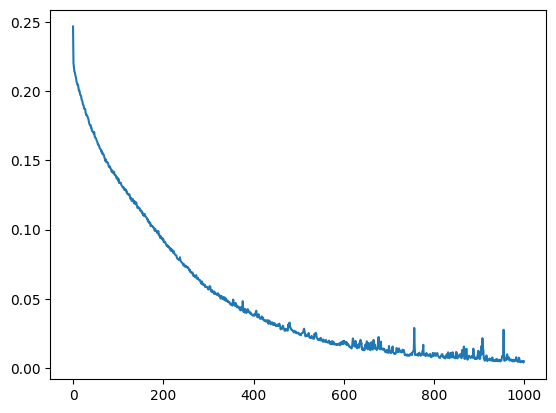

In [47]:
plt.plot(train_losses.values())

### Predict

In [51]:
def predict(model, dataset, prediction_length=25, start_with=None, static=True):
    model.eval()
    if start_with is None:
        predicted = dataset.vector_to_string([random.randint(0, len(dataset.chars) - 1)])
    else:
        predicted = start_with
    print(predicted)
    hidden = model.init_zero_hidden()

    for i in range(prediction_length - len(predicted)):
        last_char = torch.Tensor([dataset.char_to_idx[predicted[-1]]])
        X, hidden = last_char.to(device), hidden.to(device)
        out, hidden = model(X, hidden)
        if static:
            result = torch.argmax(out).item()
        else:
            result = torch.multinomial(F.softmax(out, dim=1), 1).item()

        letter = dataset.idx_to_char[result]
        if letter == '@':
            break
        predicted += letter

    return predicted

In [53]:
predict(model, text_dataset, 10, start_with="b")

b


'brauru'

### LSTM

In [54]:
class LSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.contex_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        # forget gate
        # initial weights or bias for layers in forget gate should be big positive
        self.hidden_to_forget = nn.Linear(hidden_size, hidden_size)
        self.x_to_forget = nn.Linear(input_size, hidden_size)
        # input gate
        self.hidden_to_i_input = nn.Linear(hidden_size, hidden_size)
        self.x_to_i_input = nn.Linear(input_size, hidden_size)
        self.hidden_to_context = nn.Linear(hidden_size, hidden_size)
        self.x_to_context = nn.Linear(input_size, hidden_size)
        # output gate
        self.hidden_to_output = nn.Linear(hidden_size, hidden_size)
        self.x_to_output = nn.Linear(input_size, hidden_size)
        # y
        self.hidden_to_y = nn.Linear(hidden_size, output_size)



    def forward(self, x, hidden, context):
        # forget_gate
        x_to_forget = self.x_to_forget(x)
        hidden_to_forget = self.hidden_to_forget(hidden)
        forget_out = F.sigmoid(hidden_to_forget + x_to_forget)
        context = context * forget_out
        # input gate
        i = F.sigmoid(self.hidden_to_i_input(hidden) + self.x_to_i_input(x))
        input_context = F.tanh(self.hidden_to_context(hidden) + self.x_to_context(x))
        context = context + i * input_context
        # output_gate
        hidden_to_out = self.hidden_to_output(hidden)
        x_to_out = self.x_to_output(x)
        output = F.sigmoid(hidden_to_out + x_to_out)
        context_to_out = F.tanh(context)
        hidden = context_to_out * output
        #
        y = self.hidden_to_y(hidden)
        return y, hidden, context


    def init_zero_hidden(self, batch_size=1):
        return torch.zeros(batch_size, self.hidden_size, requires_grad=False)


In [55]:
text_dataset = TextDataset(data, seq_length=seq_length)
text_dataloader = DataLoader(text_dataset, batch_size, shuffle=True, drop_last=True)

# Model
model = LSTM(1, hidden_size, len(text_dataset.chars)) # 1 because we enter a single number/letter per step.

# Train variables
epochs = 1000
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [56]:
train_losses = {}
model.to(device)
model.train()

pbar = tqdm(range(epochs))
for epoch in pbar:
    epoch_losses = list()
    for X, Y in text_dataloader:
        hidden = model.init_zero_hidden(batch_size=model.batch_size)
        context = model.init_zero_hidden(batch_size=model.batch_size)
        X, Y, hidden, context = X.to(device), Y.to(device), hidden.to(device), context.to(device)
        model.zero_grad()

        loss_value = 0
        for c in range(X.shape[1]):
            out, hidden, context = model(X[:, c].reshape(X.shape[0], 1), hidden, context)
            loss_value = loss_fn(out, Y[:, c].long())
            loss_value += loss_value

        loss_value.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 2)
        optimizer.step()

        epoch_losses.append(loss_value.detach().item() / X.shape[1])

    train_losses[epoch] = torch.tensor(epoch_losses).mean()
    pbar.set_postfix({'epoch': f'{epoch + 1}', 'loss': f'{train_losses[epoch]:.4f}'})

100%|██████████| 1000/1000 [11:43<00:00,  1.42it/s, epoch=1000, loss=0.0000]
